# Python and Dask<br>Scaling the DataFrame

# Getting started with Dask

## Training overview

* An introduction to Dask focused on tabular data.
* We will not cover all of Dask or all the APIs
* Assuming that participants have an intermediate level of experience with Pandas

## Overview by lesson
TODO: Fill in with lesson information

* Lesson 1
* Lesson 2
* Lesson 3

## Lesson Outline

* Course Setup
* 10 Minutes to Dask
* Why Dask?
* Dask APIs

## Setup for the course

You'll need to have `miniconda3` or `anaconda3` installed.

Clone the `git` repo for this course.

```bash
$ git clone -–depth 1 https://github.com/dgerlanc/dask-scaling-dataframe.git
```

Install the environment:

```bash
$ conda env create -f binder/environment.yml
```

This may take a minute or so (depends on the speed of your internet connection).

```bash
$ conda activate scale-df
```

You may also run using Binder, though you may need be more successful using the threaded scheduler.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dgerlanc/dask-scaling-dataframe/master?urlpath=lab)

## 10 minutes to Dask

* Use the Dask Dataframe API
* View the task graph
* View the distributed dashboard

In [1]:
from dask.distributed import Client
client = Client()

Click on the link for the `Dashboard` to see the distributed dashboard

## Simple setup

* Using the `distributed` scheduler
* We'll discuss scheduler options later
* Creating a `Client` starts a cluster on your local machine

In [2]:
import os
from pathlib import Path

import pandas as pd
import dask.dataframe as dd

Manually set the types here to minimize memory usage

In [3]:
data_path = "data/payroll-small"

pay_dtypes = {
    'fiscal_year': 'Int16',
    'payroll_number': None,
    'agency_name': 'category',
    'last_name': None,
    'first_name': None,
    'mid_init': None,
    'agency_start_date': object,
    'work_location_borough': 'category',
    'title_description': 'category',
    'leave_status_as_of_june_30': 'category',
    'base_salary': 'float64',
    'pay_basis': 'category',
    'regular_hours': 'float64',
    'regular_gross_paid': 'float64',
    'ot_hours': 'float64',
    'total_ot_paid': 'float64',
    'total_other_pay': 'float64',
    }

date_cols = ['agency_start_date']

all_cols = list(k for k,v in pay_dtypes.items() if v is not None)

In [4]:
pay = dd.read_csv(
    os.path.join(data_path, "payroll_*.csv"), 
    dtype=pay_dtypes,
    usecols=all_cols
)

Dask read_csv mostly follows the `pandas` options

We can use a blob (`*`) to select more than one file at a time.

To see all the arguments to `dd.read_csv`, use documentation for `pd.read_csv`

In [5]:
# ?pd.read_csv

In [6]:
# dat = pd.read_csv('nyc_payroll.csv', low_memory=False)
# cols = [x.lower().replace(' ', '_') for x in list(dat.columns)]
# dat.columns = cols
# dat.to_csv('nyc_payroll.csv', index=False)

In [7]:
pay.dtypes

fiscal_year                      Int16
agency_name                   category
agency_start_date               object
work_location_borough         category
title_description             category
leave_status_as_of_june_30    category
base_salary                    float64
pay_basis                     category
regular_hours                  float64
regular_gross_paid             float64
ot_hours                       float64
total_ot_paid                  float64
total_other_pay                float64
dtype: object

In [8]:
pay.head()

,fiscal_year,agency_name,agency_start_date,work_location_borough,title_description,leave_status_as_of_june_30,base_salary,pay_basis,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay
0,2017,DEPT OF ED PARA PROFESSIONALS,2015-09-09,MANHATTAN,SUBSTITUTE ED PARA,ACTIVE,147.37,per Day,0.0,9205.51,0.00,0.00,0.0
1,2017,BOARD OF ELECTION POLL WORKERS,2016-01-01,MANHATTAN,ELECTION WORKER,ACTIVE,1.00,per Hour,0.0,581.00,0.00,0.00,0.0
2,2017,BOROUGH PRESIDENT-QUEENS,2014-11-10,QUEENS,PUBLIC INFORMATION OFFICER,ACTIVE,100000.00,per Annum,1825.0,101329.73,0.00,0.00,0.0
3,2017,BOARD OF ELECTION POLL WORKERS,2016-01-01,MANHATTAN,ELECTION WORKER,ACTIVE,1.00,per Hour,0.0,300.00,0.00,0.00,0.0
4,2017,DEPARTMENT OF CORRECTION,2013-05-16,QUEENS,CORRECTION OFFICER,ACTIVE,55910.00,per Annum,2077.2,54479.86,592.25,23894.54,5365.7


Don't seem to have many other differences from Pandas yet...

## Partitioned Pandas

Dask DataFrames are made up of one or more Pandas DataFrames aligned along a single axis.

They do not all need to be loaded into memory at one time.

<img src="images/dask-dataframe.svg" width=250>

This [illustration](https://docs.dask.org/en/latest/_images/dask-dataframe.svg) (c) 2014-2018, Inc. and contributors.

## Dask operates on DAGs

Dask creates a directed acyclic graph (DAG) that has not yet been executed. 

Let's take a look at the task graph as this will show us how Dask is going to partition the DataFrame for us.

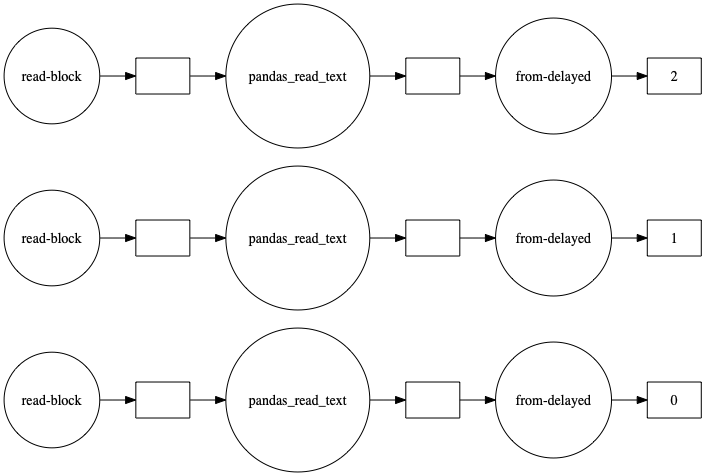

In [9]:
pay.visualize(rankdir="LR")

In [10]:
pay.npartitions

3

## Setting the number of partitions

Number of partitions is usually based on the number of the number of files and the size of each file.

In [11]:
dd.read_csv(
    os.path.join(data_path, "payroll_*.csv"), 
    dtype=pay_dtypes,
    usecols=all_cols,
    blocksize="0.5MB"
).npartitions

22

## From graph to computation

In [12]:
lazy_max = pay['base_salary'].max()
lazy_max

dd.Scalar<series-..., dtype=float64>

This doesn't look like the answer...

The reason is that Dask operates lazily. It doesn't perform a computation until you trigger it. 

Let's do that now.

In [13]:
lazy_max.compute()

302801.0

## What did Dask do for us?

We can always take a look at the task graph with `visualize`.

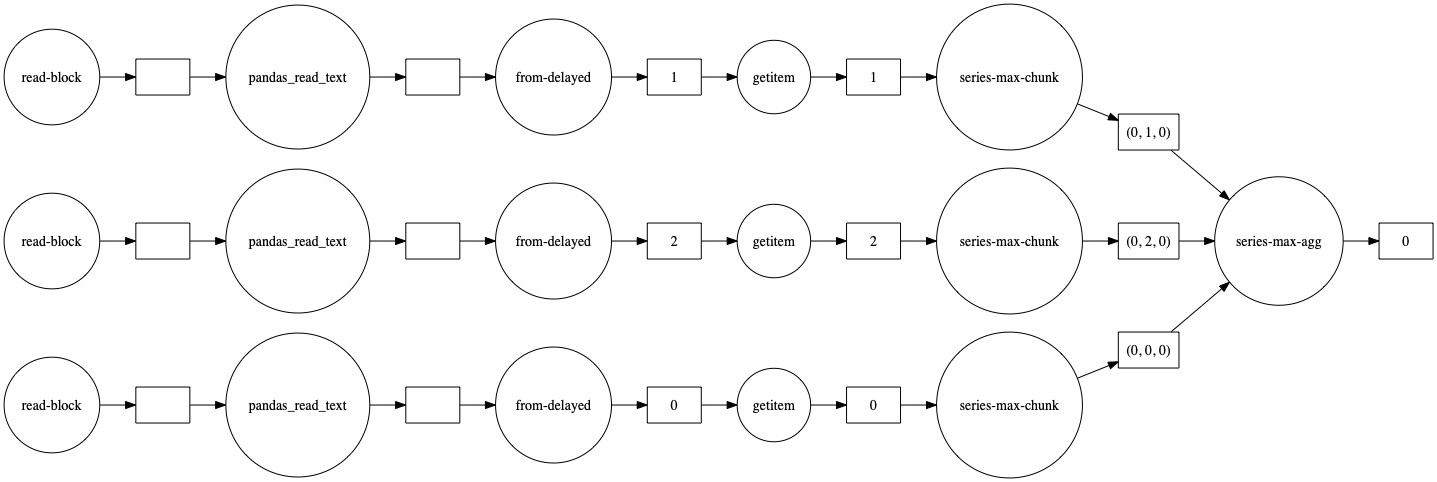

In [14]:
lazy_max.visualize(rankdir='LR')

## Dask operates out-of-memory by default

* Allows us to operate datasets that don't fit into memory without explicit chunking/streaming
* However, once we've run, data not persisted
* Need to reread the data from disk

In [15]:
pay = pay.persist()

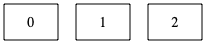

In [16]:
pay.visualize()

In [17]:
lazy_max_2 = pay['base_salary'].max()
lazy_max_2

dd.Scalar<series-..., dtype=float64>

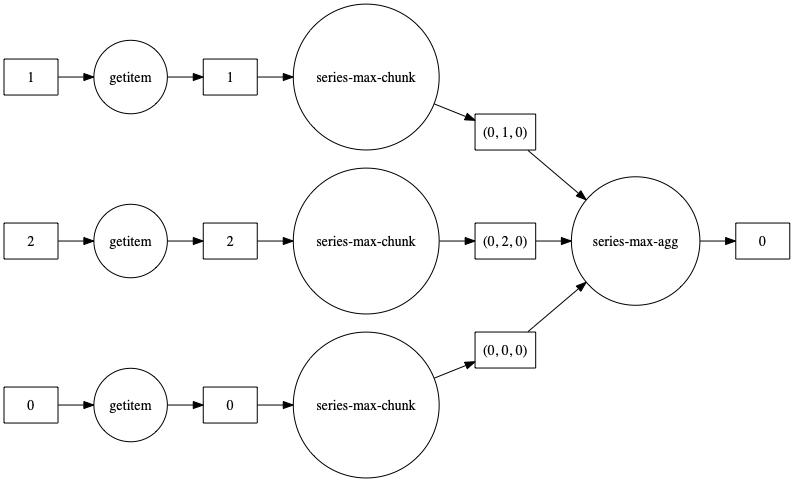

In [18]:
lazy_max_2.visualize(rankdir="LR")

## Compare to using base `pandas`

In [19]:
%%time

dfs = []
for f in Path(data_path).glob("*.csv"):
    df = pd.read_csv(f, dtype=pay_dtypes, usecols=all_cols)
    dfs.append(df)
    
pay_pd = pd.concat(dfs)

# should be 302_801
pay_pd['base_salary'].max()

CPU times: user 239 ms, sys: 35.5 ms, total: 275 ms
Wall time: 268 ms


302801.0

Once data is in memory, distributed solution is slower

In [20]:
%time pay_pd['base_salary'].max()

CPU times: user 959 µs, sys: 895 µs, total: 1.85 ms
Wall time: 961 µs


302801.0

In [21]:
%time pay['base_salary'].max().compute()

CPU times: user 13.9 ms, sys: 2.83 ms, total: 16.8 ms
Wall time: 28 ms


302801.0

## Dask Distributed Dashboard

In [22]:
client

Client Scheduler: tcp://127.0.0.1:52346 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [23]:
grp = pay.groupby('work_location_borough')

In [24]:
grp['base_salary'].agg(['mean', 'size']).compute()

,mean,size
work_location_borough,,
ALBANY,65439.413333,3
BRONX,48189.313040,4550
BROOKLYN,52074.306878,8043
DELAWARE,55038.103571,14
DUTCHESS,19961.613333,3
MANHATTAN,39640.661864,59651
NASSAU,59.312500,4
OTHER,114364.649828,1742
PUTNAM,60384.800000,5


# Why Dask?

### Python all the way down...

* Framework for parallel/distributed computing written in pure Python
* If you're already using Python, just add another package
* Integrates with existing Python environment, e.g. `numpy`, `pandas`, `sklearn`

### From laptop to cluster

* One line to start using on your laptop
* Scripts to deploy to HPC, YARN, Kubernetes, a bunch of instances over SSH...

## When to use dask

__Your problem:__

* does not fit in memory
* may be sped up though parallelism (single or multi-machine)
* custom computations that don't fit into map/filter/reduce framework

## When to not use Dask

“Parallelism and distributed computing are expensive ways to accelerate your application.”

Dask Documentation

* Does your data (easily) fit into RAM?
* Can you use profile and rewrite the slow parts in a compiled language? (or use `numba`)

# Dask APIs

“We will encourage you to develop the three great virtues of a programmer: 
laziness, impatience, and hubris.”

Larry Wall - _Programming Perl_

### High Level

* DataFrame (pandas)
* Array (like numpy)
* Bag (like pytoolz)

### Lower Level

* Delayed (Sync)
* Futures (Async)

## We're going to focus on DataFrame and Delayed

Delayed is the building-block of Dask.